# Set-Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error, r2_score, precision_recall_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import tensorflow as tf

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')

<ipython-input-101-5084b860fc20>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Loading Data

In [ ]:
url2020 = 'https://raw.githubusercontent.com/arushiag12/stock-price-prediction/main/data/processed-data/data_6weeks_2020.csv'
data2020 = pd.read_csv(url2020).drop(columns=['Unnamed: 0'])
data2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1838 entries, 0 to 1837
Columns: 182 entries, ticker to day30_volume
dtypes: float64(150), int64(30), object(2)
memory usage: 2.6+ MB


In [ ]:
url2021 = 'https://raw.githubusercontent.com/arushiag12/stock-price-prediction/main/data/processed-data/data_6weeks_2021.csv'
data2021 = pd.read_csv(url2021).drop(columns=['Unnamed: 0'])
data2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Columns: 182 entries, ticker to day30_volume
dtypes: float64(150), int64(30), object(2)
memory usage: 1.9+ MB


In [ ]:
url2022 = 'https://raw.githubusercontent.com/arushiag12/stock-price-prediction/main/data/processed-data/data_6weeks_2022.csv'
data2022 = pd.read_csv(url2022).drop(columns=['Unnamed: 0'])
data2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Columns: 182 entries, ticker to day30_volume
dtypes: float64(150), int64(30), object(2)
memory usage: 2.4+ MB


In [ ]:
url2023 = 'https://raw.githubusercontent.com/arushiag12/stock-price-prediction/main/data/processed-data/data_6weeks_2023.csv'
data2023 = pd.read_csv(url2023).drop(columns=['Unnamed: 0'])
data2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Columns: 182 entries, ticker to day30_volume
dtypes: float64(150), int64(30), object(2)
memory usage: 1.9+ MB


In [ ]:
# Specifying initial parameters

num_weeks = 6
daily_time_series = [f"day{i}_close" for i in range(1, num_weeks * 5 + 1)]
data = pd.concat([data2020, data2021, data2022, data2023], ignore_index=True)

In [ ]:
last_day = num_weeks * 5

prediction_interval = 1
interval_days_time_series = [f"day{i}_close" for i in range(last_day - prediction_interval + 1, last_day + 1)]

penultimate_day = last_day - prediction_interval

In [ ]:
# Splitting dataset into training, validation, and test datasets.

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data = train_data.drop(columns=['ticker', 'start_date'])
train_data = train_data[daily_time_series]
X_train_val = train_data.drop(columns=interval_days_time_series)
y_train_val = train_data[f'day{last_day}_close']

test_data = test_data.drop(columns=['ticker', 'start_date'])
test_data = test_data[daily_time_series]
X_test = test_data.drop(columns=interval_days_time_series)
y_test = test_data[f'day{last_day}_close']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

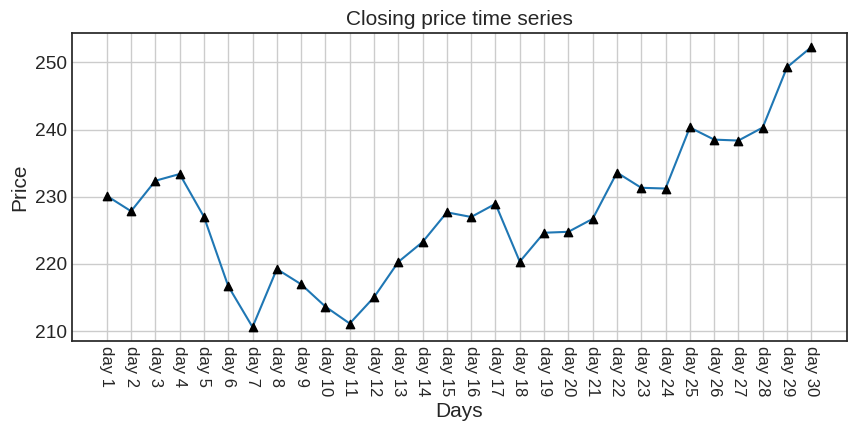

In [ ]:
# Generating sample observation

sample_row = train_data.sample(n=1).to_numpy()[0]

fig = plt.figure(figsize=(10, 4))
plt.title("Closing price time series")
plt.xlabel("Days")
plt.ylabel("Price")

plt.xticks(ticks=np.arange(30), labels=[f'day {i+1}' for i in range(30)], rotation=270, fontsize=12)

plt.plot(sample_row, color=plt.get_cmap("tab10")(0), zorder=1)
plt.scatter(np.arange(30), sample_row, color='black', marker='^', zorder=2)

plt.grid()
plt.show()

# Rebalancing Training Data


In [ ]:
def label(X, y):
    """
    Returns array of labels, 1 for 'Up', 0 for 'Down'.
    """
    return np.where(y > X[f'day{penultimate_day}_close'], 1, 0)

In [ ]:
def get_majority_label(majority_class, up_class):
    if majority_class == up_class:
        return 1
    return 0

In [ ]:
# Visualizing training data imbalance

up_class = label(X_train, y_train).sum()
down_class = label(X_train, y_train).shape[0] - up_class
majority_class = max(up_class, down_class)
minority_class = min(up_class, down_class)
difference = majority_class - minority_class
majority_label = get_majority_label(majority_class, up_class)

print("Before oversampling minority class:")
print(f"majority class = {majority_class}")
print(f"minority class = {minority_class}")
print(f"{difference = }")

Before oversampling minority class:
majority class = 2010
minority class = 1499
difference = 511


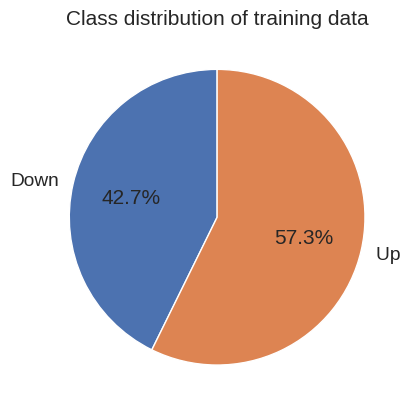

In [ ]:
plt.pie([down_class, up_class], labels=['Down', 'Up  '], autopct='%1.1f%%', startangle=90)
plt.title('Class distribution of training data')
plt.show()

In [ ]:
# Balancing training data through random oversampling

for i in range(difference):
    while True :
        resample = train_data.sample(n=1)
        X = resample.drop(columns=interval_days_time_series)
        y = resample[f'day{last_day}_close']
        if label(X, y).sum() != majority_label:
            X_train = pd.concat([X_train, X], ignore_index=True)
            y_train = pd.concat([y_train, y], ignore_index=True)
            break

up_class = label(X_train, y_train).sum()
down_class = label(X_train, y_train).shape[0] - up_class
majority_class = max(up_class, down_class)
minority_class = min(up_class, down_class)
difference = majority_class - minority_class
majority_label = get_majority_label(majority_class, up_class)

print("After oversampling minority class:")
print(f"majority class = {majority_class}")
print(f"minority class = {minority_class}")
print(f"{difference = }")

After oversampling minority class:
majority class = 2010
minority class = 2010
difference = 0


# Model Definition

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
input_shape = (X_train.shape[1], 1)
input_shape

(29, 1)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=100, input_shape=input_shape),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 200)               20200     
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 200)              

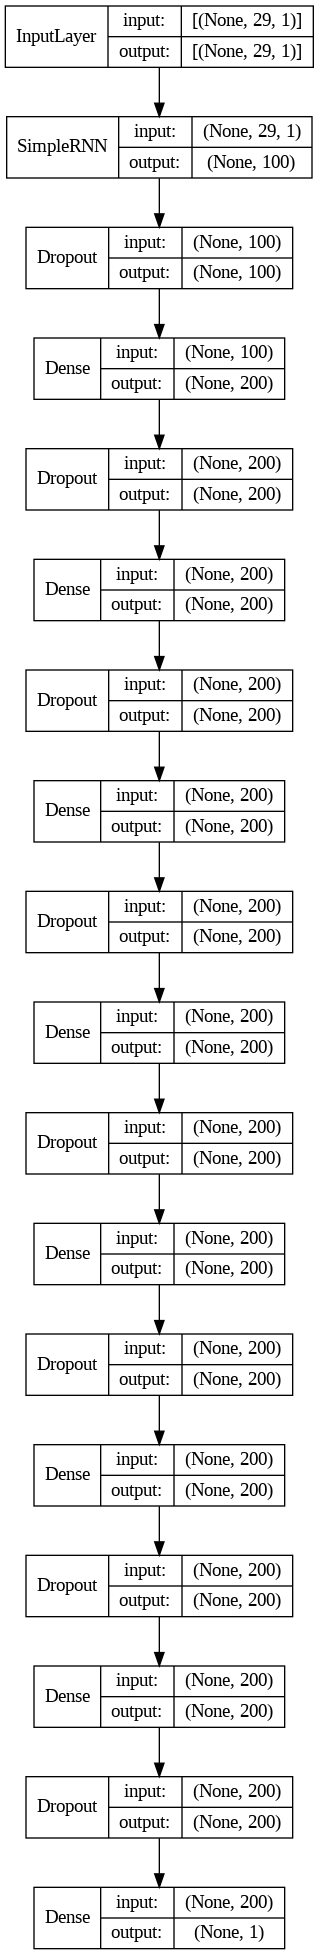

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       ])

# Model Training

In [ ]:
filepath="model_best_weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

losses = model.fit(scaler.transform(X_train).reshape(X_train.shape[0], X_train.shape[1], 1), label(X_train, y_train),
                   validation_data=(scaler.transform(X_val), label(X_val, y_val)),
                   batch_size=32,
                   epochs=300,
                   callbacks=callbacks_list,
                   verbose=True,
                   )

Epoch 1/300
123/126 [============================>.] - ETA: 0s - loss: 0.6936 - binary_accuracy: 0.5038
Epoch 1: val_loss improved from inf to 0.69339, saving model to model_best_weights.hdf5
126/126 [==============================] - 5s 19ms/step - loss: 0.6936 - binary_accuracy: 0.5030 - val_loss: 0.6934 - val_binary_accuracy: 0.4764
Epoch 2/300
 13/126 [==>...........................] - ETA: 0s - loss: 0.6927 - binary_accuracy: 0.5240

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/126 [============================>.] - ETA: 0s - loss: 0.6933 - binary_accuracy: 0.4990
Epoch 2: val_loss did not improve from 0.69339
126/126 [==============================] - 1s 10ms/step - loss: 0.6933 - binary_accuracy: 0.4973 - val_loss: 0.6948 - val_binary_accuracy: 0.4292
Epoch 3/300
122/126 [============================>.] - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.5059
Epoch 3: val_loss did not improve from 0.69339
126/126 [==============================] - 1s 10ms/step - loss: 0.6934 - binary_accuracy: 0.5057 - val_loss: 0.6938 - val_binary_accuracy: 0.4319
Epoch 4/300
126/126 [==============================] - ETA: 0s - loss: 0.6932 - binary_accuracy: 0.4938
Epoch 4: val_loss improved from 0.69339 to 0.69322, saving model to model_best_weights.hdf5
126/126 [==============================] - 1s 11ms/step - loss: 0.6932 - binary_accuracy: 0.4938 - val_loss: 0.6932 - val_binary_accuracy: 0.4764
Epoch 5/300
122/126 [============================>.] - ETA: 0s - loss: 0.693

# Results

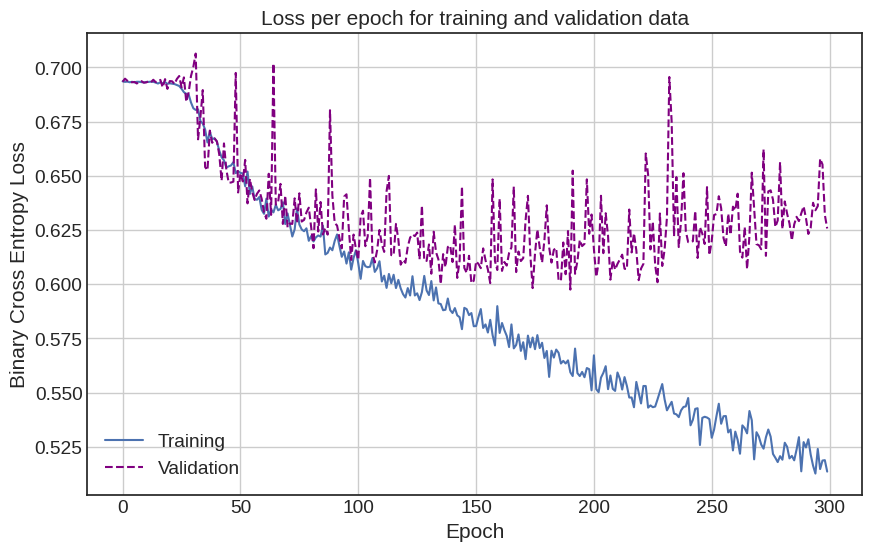

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(losses.history['loss'])
plt.plot(losses.history['val_loss'], linestyle='dashed', color='purple')
plt.title('Loss per epoch for training and validation data')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower left')
plt.grid()
plt.show()

In [ ]:
model = tf.keras.models.load_model(filepath)
pred_test_prob = model.predict(scaler.transform(X_test)).flatten()
pred_test = np.where(pred_test_prob > 0.5, 1, 0)
ytrue_test = label(X_test, y_test)

40/40 [==============================] - 0s 4ms/step


In [ ]:
print("classificaton report = ")
print(classification_report(ytrue_test, pred_test))

classificaton report = 
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       561
           1       0.67      0.78      0.72       693

    accuracy                           0.66      1254
   macro avg       0.66      0.65      0.65      1254
weighted avg       0.66      0.66      0.65      1254



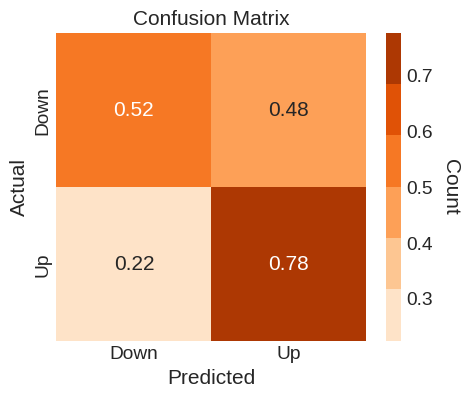

In [ ]:
cm = confusion_matrix(ytrue_test, pred_test, normalize='true')

plt.figure(figsize=(5, 4))
ax = sns.heatmap(cm, annot=True,  cmap=sns.color_palette("Oranges"), cbar=True, xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
cbar = ax.collections[0].colorbar
cbar.set_label('Count', rotation=270, labelpad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(ytrue_test, pred_test_prob)
roc_auc = roc_auc_score(ytrue_test, pred_test_prob)

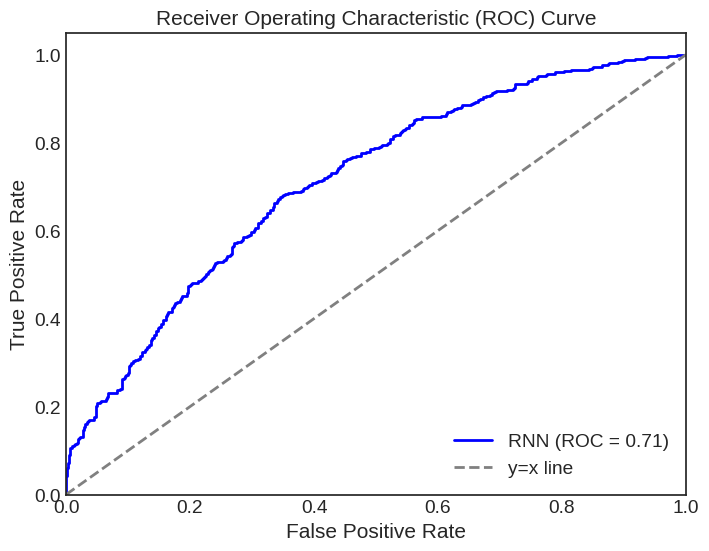

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, color='blue', label=f'RNN (ROC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='y=x line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 17ms/step


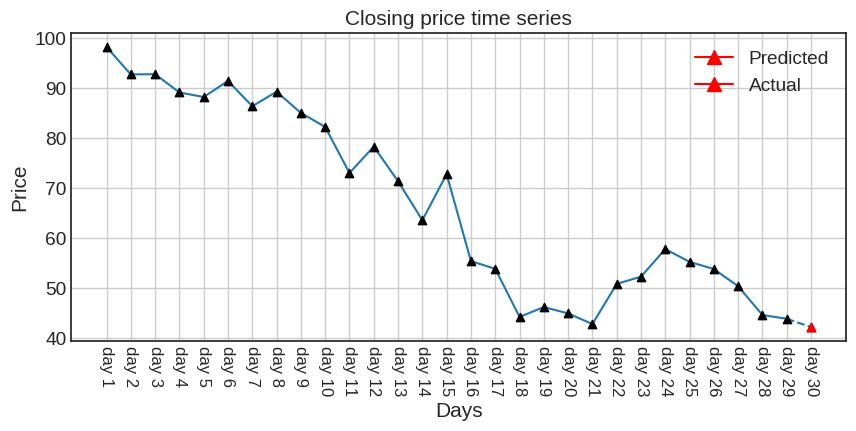

In [ ]:
sample_row = test_data.sample(n=1)
X = sample_row.drop(columns=interval_days_time_series)
y = sample_row[f'day{last_day}_close']

ytrue = label(X, y)
pred_prob = model.predict(scaler.transform(X).reshape(1, -1))
pred = 1 if pred_prob > 0.5 else 0

color_true = 'green' if ytrue == 1 else 'red'
color_pred = 'green' if pred == 1 else 'red'

fig = plt.figure(figsize=(10, 4))
plt.title("Closing price time series")
plt.xlabel("Days")
plt.ylabel("Price")

plt.xticks(ticks=np.arange(30), labels=[f'day {i+1}' for i in range(30)], rotation=270, fontsize=12)
plt.plot(X.to_numpy()[0], color=plt.get_cmap("tab10")(0), zorder=1)
plt.scatter(np.arange(30), sample_row, color='black', marker='^', zorder=2)
plt.plot([28, 29], [X.to_numpy()[0][-1], y.values[0]], color=plt.get_cmap("tab10")(0), linestyle='dashed', zorder=1)
plt.scatter([29], [y.values[0]], color=color_true, marker='^', zorder=2 )

legend_elements = [Line2D([0], [0], marker='^', color=color_pred, label='Predicted', markersize=10),
                   Line2D([0], [0], marker='^', color=color_true, label='Actual', markersize=10),]
plt.legend(handles=legend_elements)

plt.grid()
plt.show()